In [ ]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from pymannkendall import original_test
from scipy.stats import kruskal
import scikit_posthocs as sp

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
paises_brics = ['MSCI BRAZIL', 'MSCI SOUTH AFRICA', 'MSCI CHINA', 'MSCI INDIA', 'MSCI RUSSIA']

In [12]:
etfs_brics = pd.read_csv('ETF_data_yfinance_formatado.csv', index_col='Date', parse_dates=True,
                        usecols=['Date']+paises_brics)

etfs_brics.head()

,MSCI BRAZIL,MSCI CHINA,MSCI INDIA,MSCI SOUTH AFRICA,MSCI RUSSIA
Date,,,,,
NaT,EWZ,MCHI,INDA,EZA,ERUS
2016-01-04,12.360641479492188,36.29214859008789,23.988008499145508,29.382587432861328,11.363970756530762
2016-01-05,12.534207344055176,36.258453369140625,24.219690322875977,29.48567008972168,11.552149772644043
2016-01-06,12.34824275970459,35.65176010131836,23.86325454711914,28.5902156829834,11.33260726928711
2016-01-07,11.88952350616455,34.194000244140625,23.105833053588867,27.147165298461914,10.914430618286133


In [13]:
etfs_brics.tail()

,MSCI BRAZIL,MSCI CHINA,MSCI INDIA,MSCI SOUTH AFRICA,MSCI RUSSIA
Date,,,,,
2025-06-27,28.139999389648438,55.18000030517578,55.86000061035156,52.63999938964844,8.0600004196167
2025-06-30,28.850000381469727,55.099998474121094,55.68000030517578,53.75,8.0600004196167
2025-07-01,28.790000915527344,55.27000045776367,55.84000015258789,54.209999084472656,8.0600004196167
2025-07-02,28.90999984741211,55.0,55.599998474121094,54.310001373291016,8.0600004196167
2025-07-03,29.309999465942383,54.720001220703125,55.790000915527344,54.790000915527344,8.0600004196167


In [14]:
etfs_brics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2390 entries, NaT to 2025-07-03
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   MSCI BRAZIL        2390 non-null   object
 1   MSCI CHINA         2390 non-null   object
 2   MSCI INDIA         2390 non-null   object
 3   MSCI SOUTH AFRICA  2390 non-null   object
 4   MSCI RUSSIA        2390 non-null   object
dtypes: object(5)
memory usage: 112.0+ KB


In [15]:
etfs_brics.index = pd.to_datetime(etfs_brics.index, format='%Y-%m-%d')

In [16]:
fundos_indices = etfs_brics.iloc[0, :]
etfs_brics = etfs_brics.iloc[1:, :]

In [ ]:
for pais in paises_brics:
    etfs_brics[pais] = pd.to_numeric(etfs_brics[pais])

# Análise 

In [25]:
ano_mes_media = etfs_brics.groupby([etfs_brics.index.year, etfs_brics.index.month])['MSCI BRAZIL'].mean()

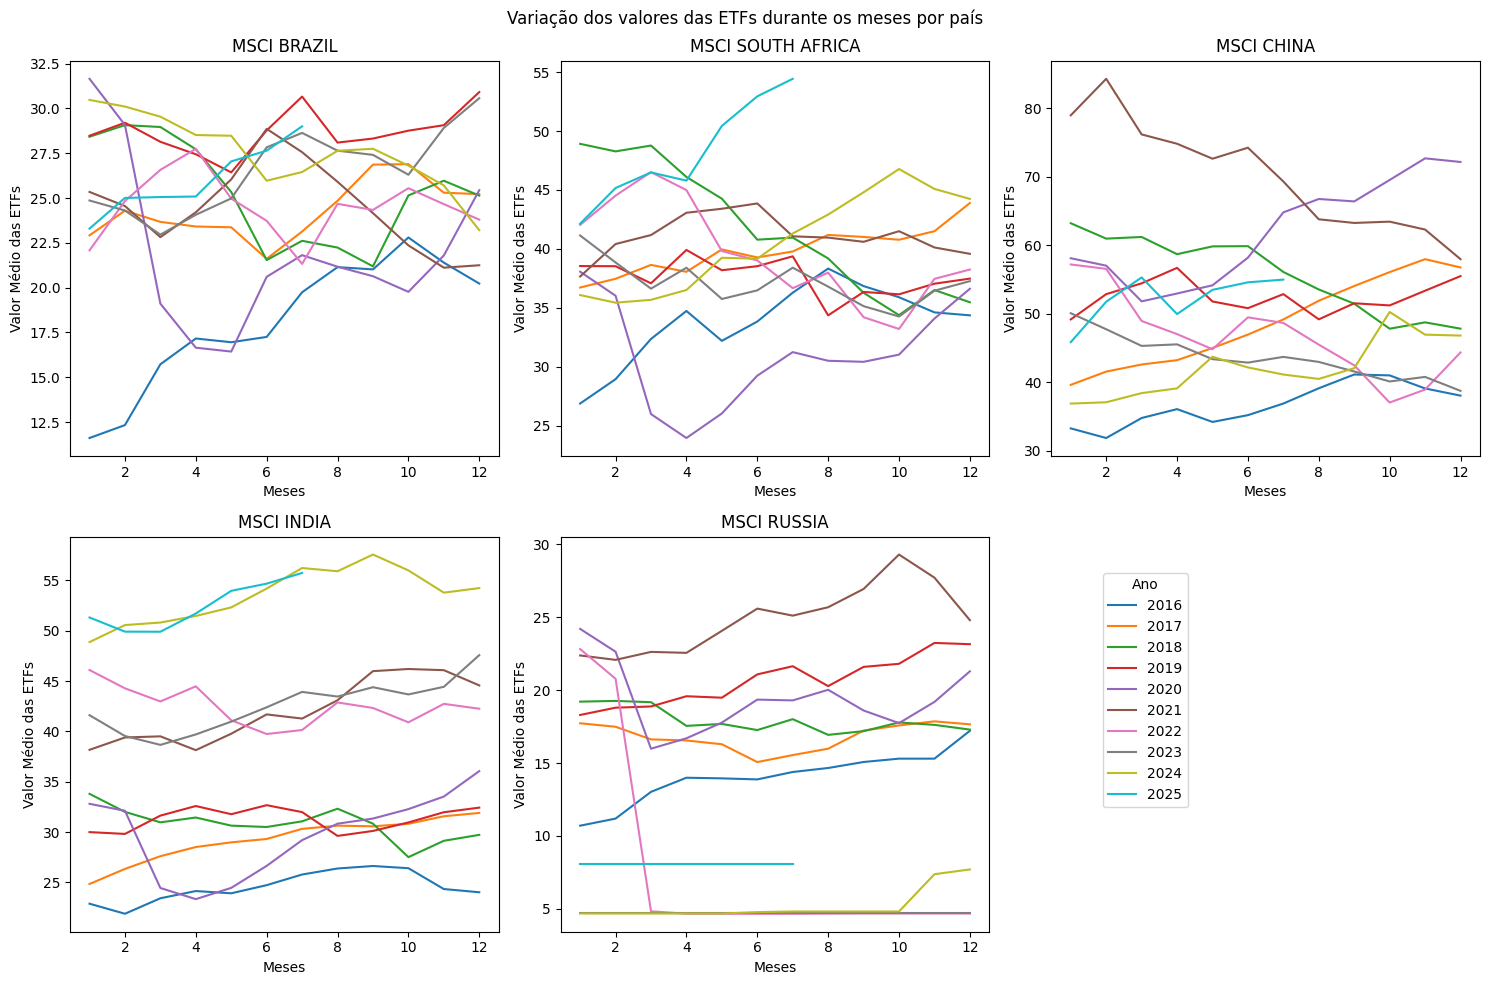

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten() 

for i, pais in enumerate(paises_brics):
    ax = axs[i]
    ano_mes_media = etfs_brics.groupby([etfs_brics.index.year, etfs_brics.index.month])[pais].mean()

    sns.lineplot(
        x=ano_mes_media.index.get_level_values(1),
        y=ano_mes_media.values,
        hue=ano_mes_media.index.get_level_values(0),
        palette='tab10',
        ax=ax
    )

    ax.set_title(pais)
    ax.set_xlabel('Meses')
    ax.set_ylabel('Valor Médio das ETFs')

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    ax.legend_.remove()

for j in range(len(paises_brics), 6):
    fig.delaxes(axs[j])
    
fig.legend(
    handles,
    labels,
    title='Ano',
    loc='center right',
    bbox_to_anchor=(0.8, 0.3),
    ncol=1
)

plt.suptitle('Variação dos valores das ETFs durante os meses por país')
plt.tight_layout()
plt.show()


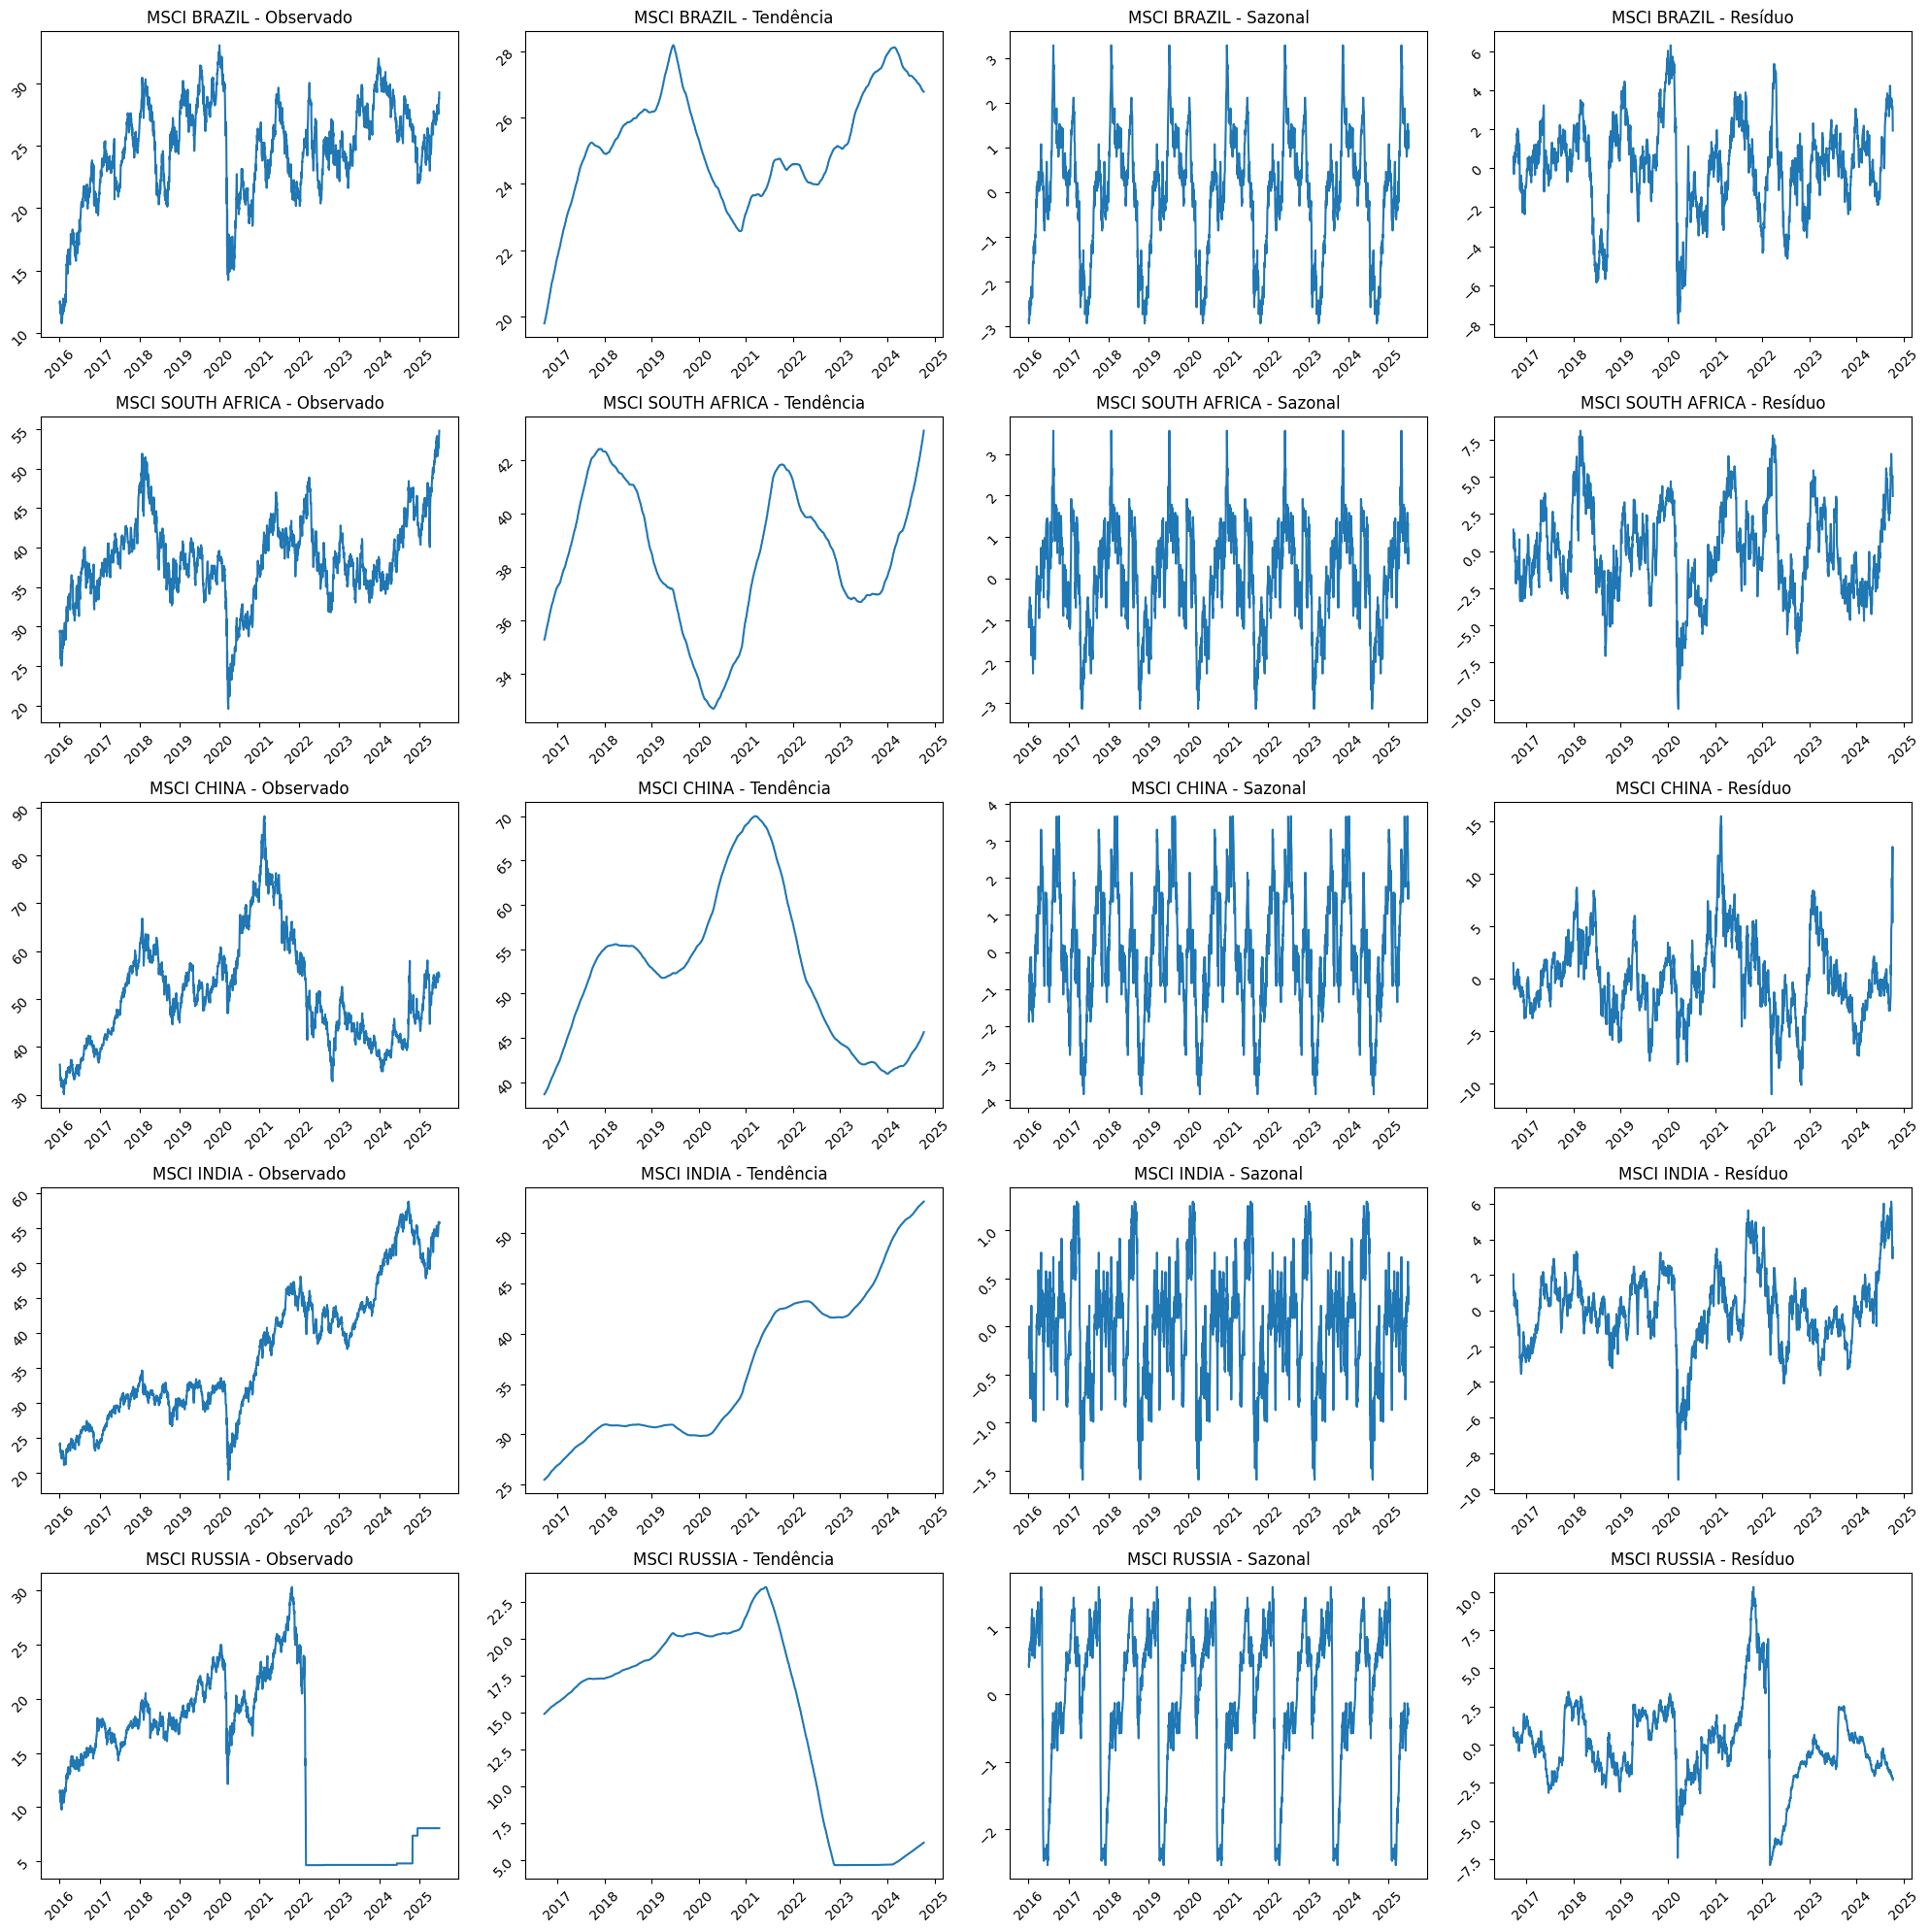

In [ ]:
fig, axs = plt.subplots(len(paises_brics), 4, figsize=(20, 4 * len(paises_brics)))

for i, pais in enumerate(paises_brics):
    serie = etfs_brics[pais].dropna()
    
    result = seasonal_decompose(serie, model='additive', period=365)

    axs[i, 0].plot(result.observed)
    axs[i, 0].set_title(f'{pais} - Observado')

    axs[i, 1].plot(result.trend)
    axs[i, 1].set_title(f'{pais} - Tendência')

    axs[i, 2].plot(result.seasonal)
    axs[i, 2].set_title(f'{pais} - Sazonal')

    axs[i, 3].plot(result.resid)
    axs[i, 3].set_title(f'{pais} - Resíduo')

    for j in range(4):
        axs[i, j].tick_params(labelrotation=45)

plt.suptitle('Decomposição dos dados')
plt.tight_layout()
plt.show()


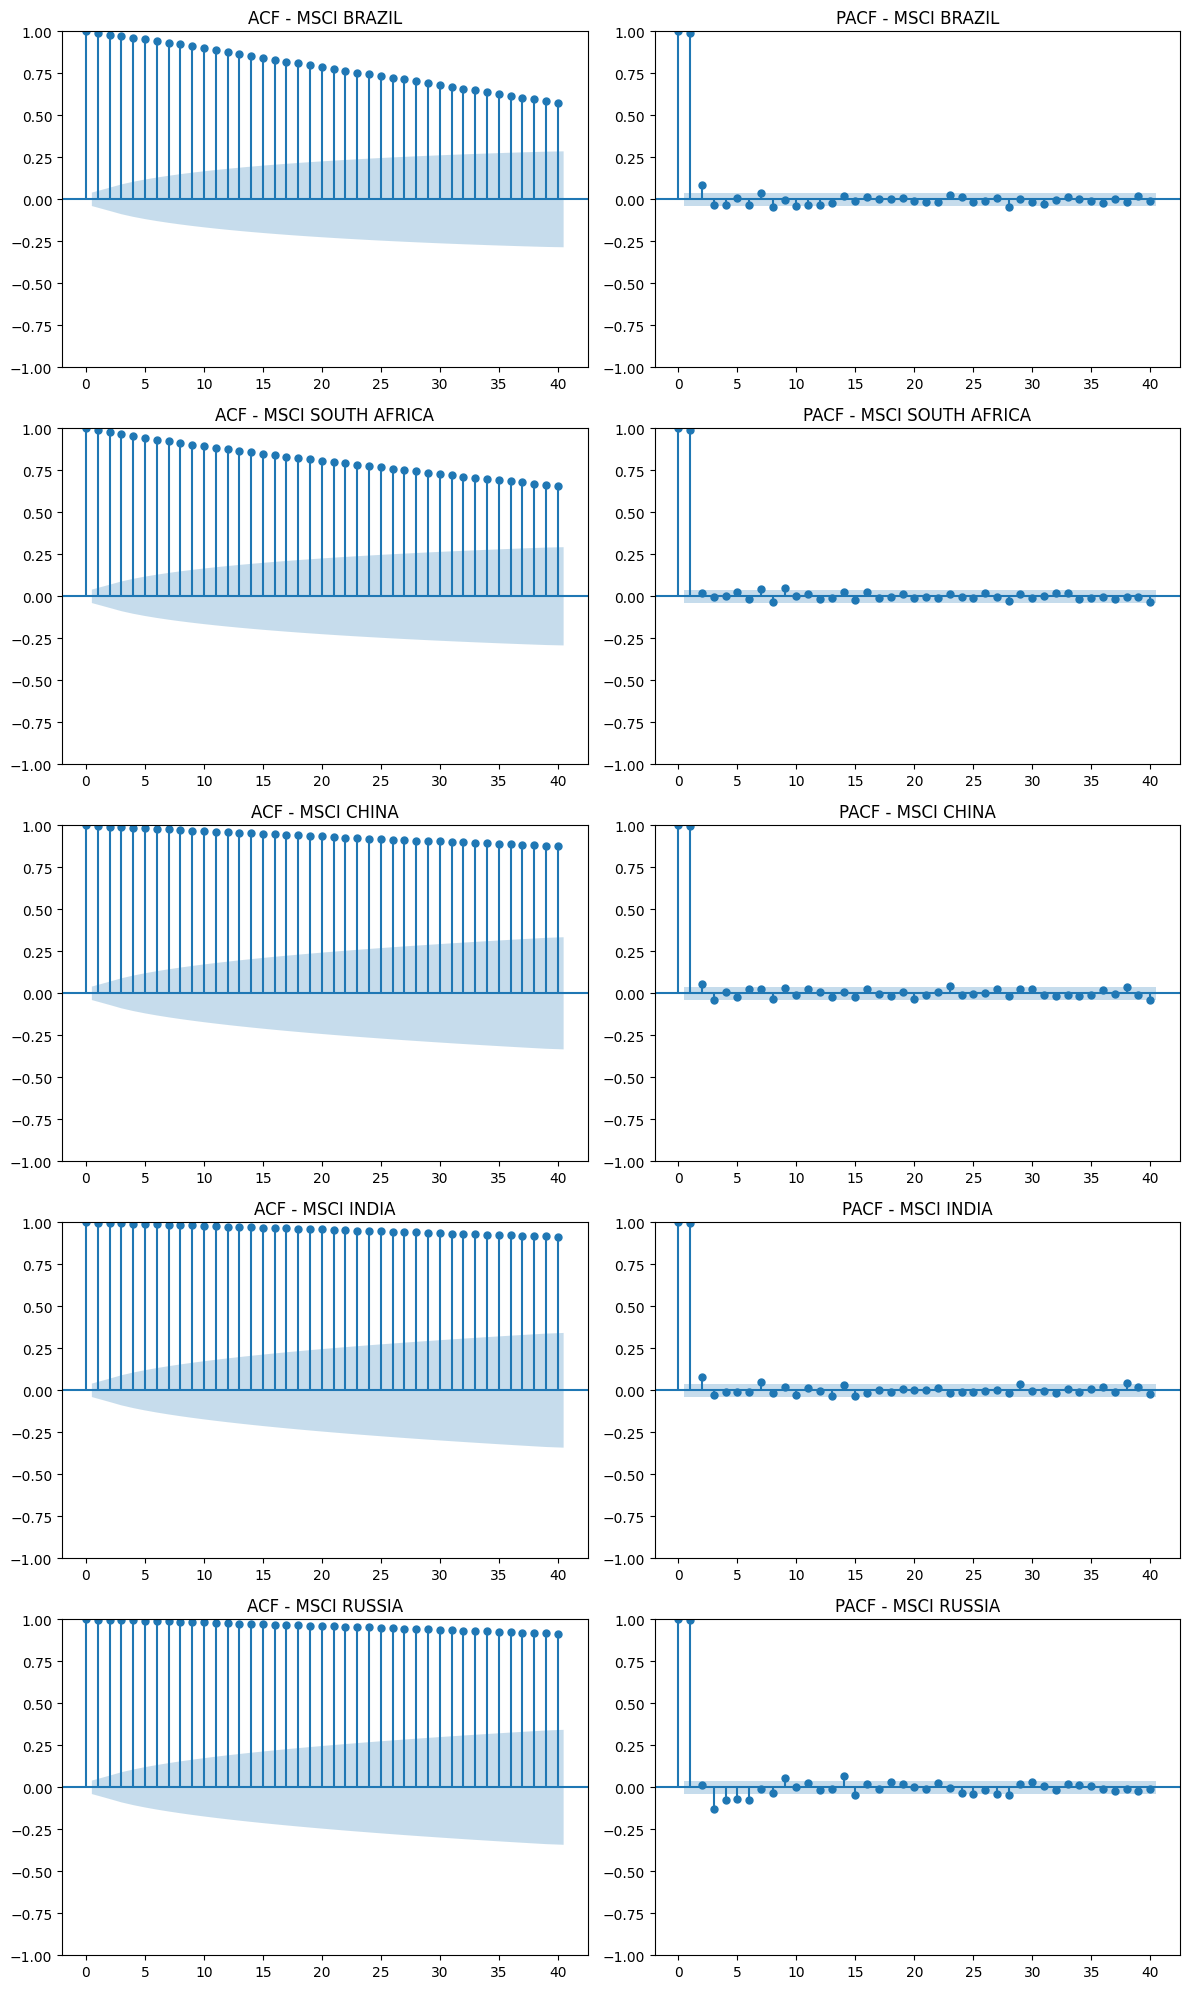

In [127]:
fig, axs = plt.subplots(5, 2, figsize=(12, 20))


for i, pais in enumerate(paises_brics):
    serie = etfs_brics[pais].dropna()


    plot_acf(serie, ax=axs[i, 0], lags=40)
    axs[i, 0].set_title(f'ACF - {pais}')

    plot_pacf(serie, ax=axs[i, 1], lags=40, method='ywm') 
    axs[i, 1].set_title(f'PACF - {pais}')

plt.tight_layout()
plt.show()


# Testes de hipóteses

## .1 Teste de Estacionaridade

Teste de Dickey-Fuller

H0: Série temporal não é estacionária

H1: Série temporal  é estacionária

In [66]:
for pais in paises_brics:
    print('--'*10)

    print(f'Teste ADF para {pais}')
    resultado = adfuller(etfs_brics[pais])

    print('Estatística ADF:', resultado[0])
    print('p-valor:', resultado[1])
    print('Valores críticos:', resultado[4])
    
    if resultado[1] <= 0.05:
        print("A série é estacionária (rejeita-se a hipótese nula)")
    else:
        print("A série não é estacionária (não rejeita a hipótese nula)")

--------------------
Teste ADF para MSCI BRAZIL
Estatística ADF: -4.323341676191362
p-valor: 0.00040463685764351723
Valores críticos: {'1%': np.float64(-3.433104049600873), '5%': np.float64(-2.862756696812544), '10%': np.float64(-2.5674176995127014)}
A série é estacionária (rejeita-se a hipótese nula)
--------------------
Teste ADF para MSCI SOUTH AFRICA
Estatística ADF: -2.6072596237234933
p-valor: 0.09150611439248213
Valores críticos: {'1%': np.float64(-3.433100574354779), '5%': np.float64(-2.862755162210213), '10%': np.float64(-2.5674168824588657)}
A série não é estacionária (não rejeita a hipótese nula)
--------------------
Teste ADF para MSCI CHINA
Estatística ADF: -2.1781556676659997
p-valor: 0.21426899086543122
Valores críticos: {'1%': np.float64(-3.4330936501081823), '5%': np.float64(-2.8627521045897844), '10%': np.float64(-2.5674152545197644)}
A série não é estacionária (não rejeita a hipótese nula)
--------------------
Teste ADF para MSCI INDIA
Estatística ADF: -0.69054930261

## .2 Teste de Tendência

Teste de Mann-Kendall

H0: Não tem tendência na série temporal

H1: Tem tendência na série temporal

In [72]:
for pais in paises_brics:
    print('--'*10)

    print(f'Teste MK para {pais}')
    resultado = original_test(etfs_brics[pais])

    print(f"Valor-p: {resultado.p}")
    print(f"Estatística Z: {resultado.z}")
    print(f"Tau de Kendall: {resultado.Tau}")
    
    if resultado.p < 0.05:
        print("Há uma tendência estatisticamente significativa.")
    else:
        print("Não há uma tendência estatisticamente significativa.")

--------------------
Teste MK para MSCI BRAZIL
Valor-p: 0.0
Estatística Z: 19.5575142382008
Tau de Kendall: 0.26695182343978857
Há uma tendência estatisticamente significativa.
--------------------
Teste MK para MSCI SOUTH AFRICA
Valor-p: 0.0
Estatística Z: 13.516431277258361
Tau de Kendall: 0.1844936977338205
Há uma tendência estatisticamente significativa.
--------------------
Teste MK para MSCI CHINA
Valor-p: 0.18933473996430372
Estatística Z: 1.3125496657823092
Tau de Kendall: 0.017916076826156736
Não há uma tendência estatisticamente significativa.
--------------------
Teste MK para MSCI INDIA
Valor-p: 0.0
Estatística Z: 54.192042576679555
Tau de Kendall: 0.7396978614293738
Há uma tendência estatisticamente significativa.
--------------------
Teste MK para MSCI RUSSIA
Valor-p: 2.7494717613762987e-10
Estatística Z: -6.31228393892774
Tau de Kendall: -0.08584326684349612
Há uma tendência estatisticamente significativa.


## .3 Teste de Sazonalidade

Teste de Friedman e Teste de Dunn 

H0: A média de cada população é igual.

Ha: Pelo menos uma média populacional é diferente das demais.

In [132]:
for pais in paises_brics:
    print('--'*20)
    print(pais)
    etfs_por_ano = etfs_brics.groupby(etfs_brics.index.year)[pais].apply(list)
    estatistica, pvalor = kruskal(*etfs_por_ano.values)

    print(f"Valor-p: {pvalor}")
    print(f"Estatística Z: {estatistica}")

    if pvalor < 0.05:
        print("Pelo menos uma distribuição é diferente das demais")
    else:
        print("Distribuição de cada ano é igual")


----------------------------------------
MSCI BRAZIL
Valor-p: 5.2776979138202135e-253
Estatística Z: 1201.6735318972303
Pelo menos uma distribuição é diferente das demais
----------------------------------------
MSCI SOUTH AFRICA
Valor-p: 1.873289607403772e-260
Estatística Z: 1236.1791558473233
Pelo menos uma distribuição é diferente das demais
----------------------------------------
MSCI CHINA
Valor-p: 0.0
Estatística Z: 1815.792537023792
Pelo menos uma distribuição é diferente das demais
----------------------------------------
MSCI INDIA
Valor-p: 0.0
Estatística Z: 2111.932743284091
Pelo menos uma distribuição é diferente das demais
----------------------------------------
MSCI RUSSIA
Valor-p: 0.0
Estatística Z: 2004.2396208514906
Pelo menos uma distribuição é diferente das demais


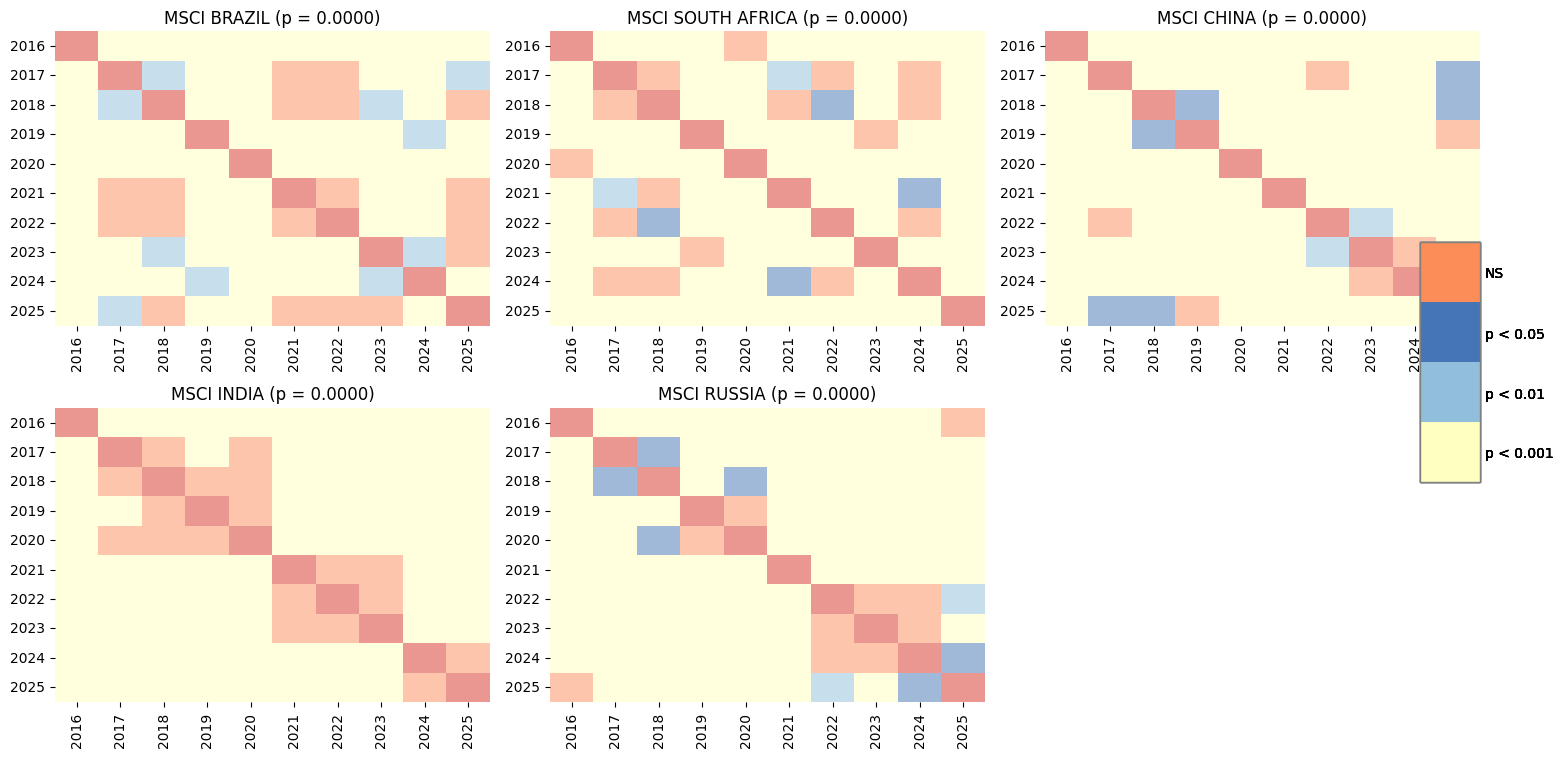

In [ ]:
cmap_personalizado = ['#d73027', '#fc8d59', '#ffffbf', '#91bfdb', '#4575b4']

n = len(paises_brics)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for i, pais in enumerate(paises_brics):
    df = pd.DataFrame({'valor': etfs_brics[pais]})
    df['ano'] = df.index.year
    grupos = [grupo['valor'].values for _, grupo in df.groupby('ano')]
    stat, pval = kruskal(*grupos)

    ax = axs[i]

    if pval < 0.05:
        dunn_result = sp.posthoc_dunn(df, val_col='valor', group_col='ano', p_adjust='bonferroni')

        sp.sign_plot(dunn_result, alpha=0.5, ax=ax, cmap=cmap_personalizado)
        ax.set_title(f"{pais} (p = {pval:.4f})")
    else:
        ax.axis('off')
        ax.set_title(f"{pais} - sem diferenças significativas (p = {pval:.4f})")

for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()